# Web Applications with Flask

In networking *clients* are computers or programs that send requests; *servers* are computers or programs that respond to those requests.

Any web browser is an example of a client.  You have also written Python programs with `requests` and/or `selenium` that make requests, and thus are clients.

In this reading, we'll focus on the other side: servers.  As a data scientist, working with data dashboards (with live stats, plots, etc) is one scenario where you may find yourself writing server code.

There are many Python packages to help write web servers.  Django is the most popular.  We'll use the second most popular, Flask, as it is much easier to learn.

## Preliminary Setup

Before we make a web server, we'll create a selenium browser because we'll need a client to test our server's ability to respond to requests.  We'll also create a simple `visit` function that shows us what is available at a given URL.

In [2]:
import time
import requests
from IPython.core.display import Image
from multiprocessing import Process

from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from IPython.core.display import Image, display
import pandas as pd

options = Options()
options.headless = True # headless means "no graphical interface"
service = Service(executable_path="chromium.chromedriver")
b = webdriver.Chrome(options=options, service=service)

def visit(url, source=False):
    if source:
        r = requests.get(url)
        return r.text
    else:
        b.get(url)
        b.save_screenshot("tmp.png")
        return Image("tmp.png")

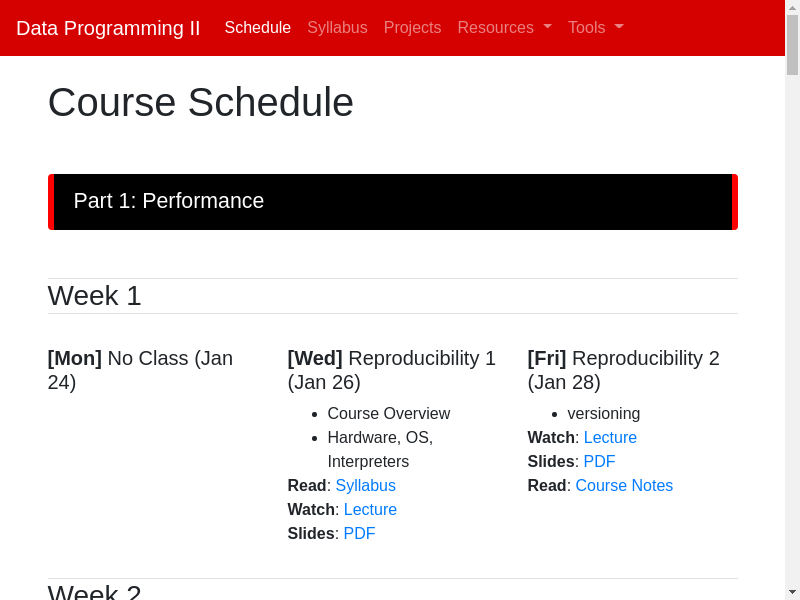

In [3]:
# test it on the course website
visit("https://tyler.caraza-harter.com/cs320/s22/schedule.html")

In [4]:
print(visit("https://tyler.caraza-harter.com/cs320/s22/schedule.html", source=True)[:500] + "\n...")

<!doctype html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <meta name="description" content="">
    <meta name="author" content="">

    <!-- Google Auth stuff -->
    <meta name="google-signin-scope" content="profile email">
    <meta name="google-signin-client_id" content="531980636037-3a6miiekf2ao8d0n7qv1fkrev8cbvvdt.apps.googleusercontent.com">

    <title>Tyler R. Caraza-Harter</title>


...


## Flask Basics

We be using Flask application objects (which we can name as we please) to create web servers:

In [5]:
from flask import Flask, request

my320app = Flask("example-server")
type(my320app)

flask.app.Flask

To add pages to a Flask application, you write a function (called a *handler*) for each page; the function returns a string containing HTML corresponding to the page.

Flask uses *routes* to map URLs to handler functions.  Putting `@APPLICATION_VARIABLE.route("/SOME_PATH_HERE")` before a function to make it a handler for the given URL.

In [6]:
@my320app.route("/")
def home():
    return "Home"

@my320app.route("/hello.html")
def handler1():
    return '<html><body style="background-color:lightblue"><i>hello</i><body></html>'

@my320app.route("/world.html")
def handler2():
    return '<html><body style="background-color:lightgreen"><h1>world</h1><body></html>'

#if __name__ == '__main__':
#    app.run("0.0.0.0", "5000")

Generally, Flask applications are written as .py files.  You could paste the above two cells into a .py file, uncomment those last two lines, then run the .py file to start a server running your application.  Requests may keep coming in indefinitely, so the `app.run` function would essentially run forever, dealing with requests as they come in (well, at least until you manually killed it with `CONTROL`-`C`, `pkill`, or some other method).

For the purposes of having our Flask server and selenium client in the same notebook, we'll do something a bit weird: run the server in the background from a cell, then send requests from the following code.  The following code starts the flask application in the background (don't worry about understanding it, as you'll probably use .py files for your own Flask applications, unless you yourself are writing a document like this to document Flask).

In [7]:
p = Process(target=my320app.run)
p.start()
time.sleep(1) # give it time to get going

 * Serving Flask app 'example-server' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Mar/2022 00:46:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2022 00:46:04] "GET /hello.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2022 00:46:05] "GET /world.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2022 00:46:07] "GET /missing.html HTTP/1.1" 404 -
127.0.0.1 - - [09/Mar/2022 00:46:11] "GET /hello.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2022 00:46:13] "GET /world.html HTTP/1.1" 200 -


The "Running ..." line above shows that we can visit the page at http://127.0.0.1:5000/.  Note that 127.0.0.1 is a special "local" IP address, referring to the computer where the code is running.  Let's send requests to see the strings returned by those three pages.  You can see "GET ..." messages above corresponding to page visits.  As this notebook was executed, those messages were added above as code below executed.

In [8]:
visit("http://127.0.0.1:5000/", source=True) # calls "home" function after @my320app.route("/")

'Home'

In [9]:
visit("http://127.0.0.1:5000/hello.html", source=True) # calls handler1

'<html><body style="background-color:lightblue"><i>hello</i><body></html>'

In [10]:
visit("http://127.0.0.1:5000/world.html", source=True) # calls handler2

'<html><body style="background-color:lightgreen"><h1>world</h1><body></html>'

If we try a page that doesn't exist (that is, no route maps it to a handler), Flask will automatically return HTML (as a string) containing an error message.

In [11]:
visit("http://127.0.0.1:5000/missing.html", source=True)

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>404 Not Found</title>\n<h1>Not Found</h1>\n<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>\n'

When a web browser receives one of the above strings containing HTML, it uses it to show a formatted page:

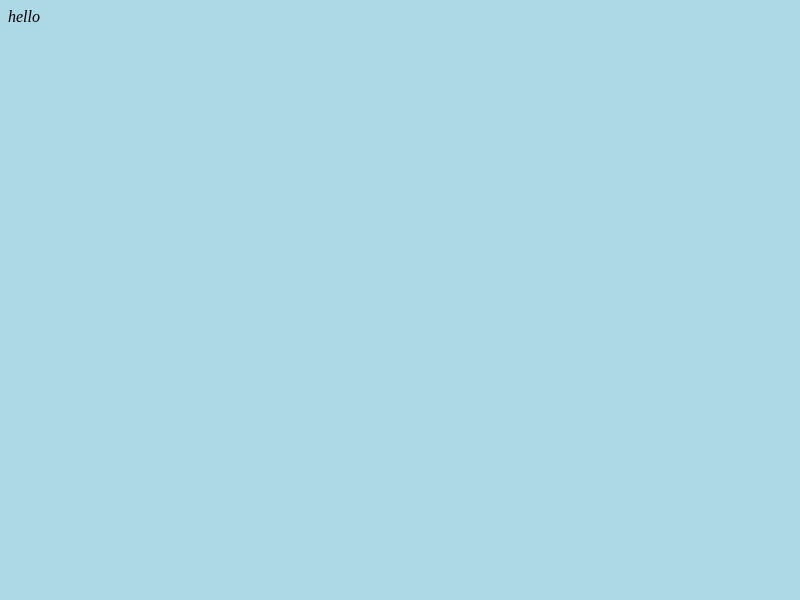

In [12]:
visit("http://127.0.0.1:5000/hello.html")

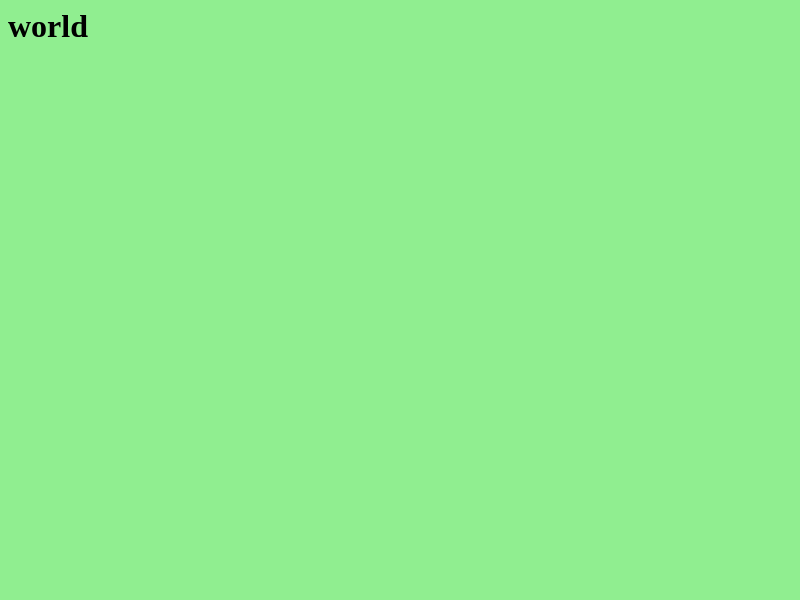

In [13]:
visit("http://127.0.0.1:5000/world.html")

The ":5000" part of the above URLs means Flask is *listening* on port 5000.  Only one process can listen on each port at a time.  We could start other Flask servers on other ports, but we will get an "Address already in use" error if we try again on the same port:

In [14]:
try:
    my320app.run("127.0.0.1", "5000")
except OSError as e:
    print(e)

 * Serving Flask app 'example-server' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
[Errno 98] Address already in use


We will need to terminate the previous background Flask instance before starting anything else on port 5000.

In [15]:
p.terminate()

## Query Strings

Sometimes, we'll want to send input to a Flask handler that it can use when constructing the output.  One way is with a query string.

Consider this URL: `http://127.0.0.1:5000/hello.html?name=tyler`.  There are a few parts to this:
* **protocol** is "HTTP"
* **IP address** of machine is "127.0.0.1"
* **port number** of process on machine is "5000"
* **resource** is "/hello.html"
* **query string** is "name=tyler"

The resource is what we'll use with the Flask route.  The query string gets loaded to a kind of dictionary called `request.args`, where "name" is a key and "tyler" is a value.

In [16]:
app2 = Flask("example-server")

@app2.route("/hello.html")
def welcome():
    print(request.args)
    username = request.args["name"]
    return f'<h1>Welcome {username}!</h1>'

p = Process(target=app2.run)
p.start()
time.sleep(1) # give it time to get going

 * Serving Flask app 'example-server' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


ImmutableMultiDict([('name', 'tyler')])


127.0.0.1 - - [09/Mar/2022 00:46:20] "GET /hello.html?name=tyler HTTP/1.1" 200 -


ImmutableMultiDict([('name', 'tyler')])


127.0.0.1 - - [09/Mar/2022 00:46:20] "GET /hello.html?name=tyler HTTP/1.1" 200 -


In [17]:
visit("http://127.0.0.1:5000/hello.html?name=tyler", source=True)

'<h1>Welcome tyler!</h1>'

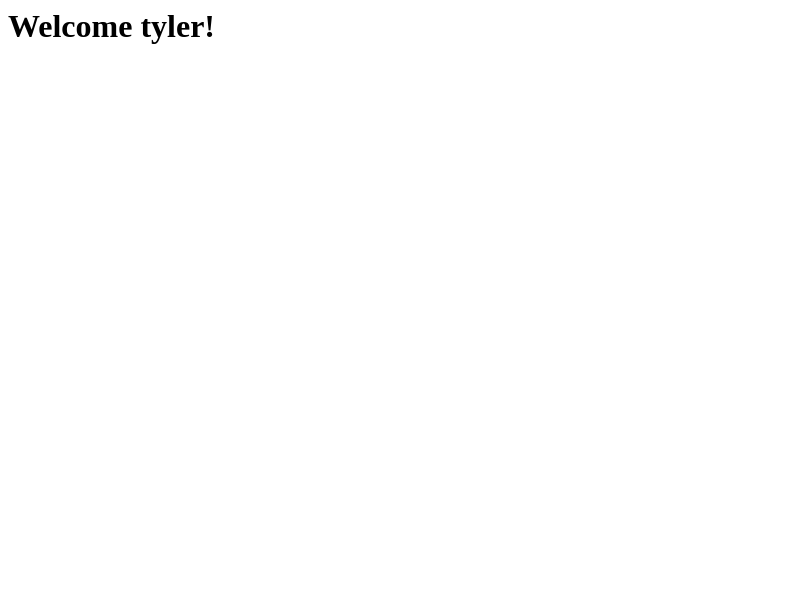

In [18]:
visit("http://127.0.0.1:5000/hello.html?name=tyler")

In [19]:
p.terminate()

If there are multiple arguments in the query string, you can just use the `&` symbol to separate the key/value pairs: `?key1=val1&key2=val2`.  Below is an example of pages that do arithmatic.  They also use multi-line strings via the triple quotes.  The `.format` method replaces the `{}` slots in the string template.

In [20]:
app2 = Flask("example-server")

@app2.route("/add.html")
def add():
    x = float(request.args["x"])
    y = float(request.args["y"])
    total = x + y
    html = """
    <html>
      <body style="background-color:lightblue">
        <h1>ADD</h1>
        {} + {} = {}
      <body>
    </html>
    """
    return html.format(x, y, total)

@app2.route("/subtract.html")
def sub():
    x = float(request.args["x"])
    y = float(request.args["y"])
    total = x - y
    html = """
    <html>
      <body style="background-color:lightblue">
        <h1>SUB</h1>
        {} - {} = {}
      <body>
    </html>
    """
    return html.format(x, y, total)

p = Process(target=app2.run)
p.start()
time.sleep(1) # give it time to get going

 * Serving Flask app 'example-server' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Mar/2022 00:46:27] "GET /add.html?x=300&y=20 HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2022 00:46:28] "GET /subtract.html?x=1000&y=1 HTTP/1.1" 200 -


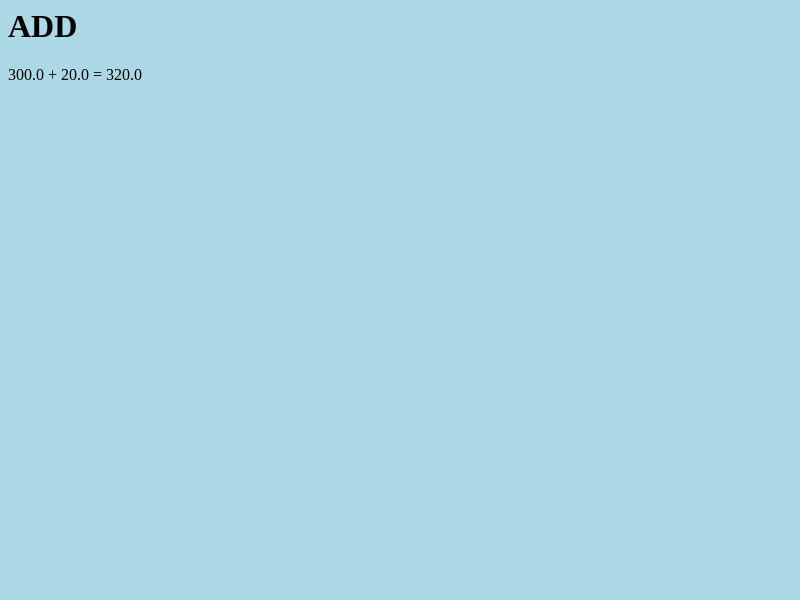

In [21]:
visit("http://127.0.0.1:5000/add.html?x=300&y=20")

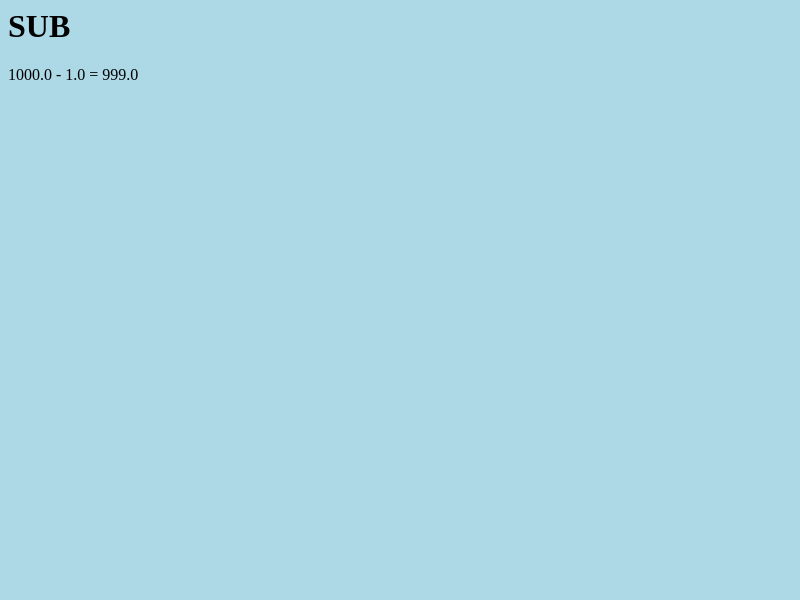

In [22]:
visit("http://127.0.0.1:5000/subtract.html?x=1000&y=1")

In [23]:
p.terminate()

In [24]:
# cleanup Selenium
b.close()